In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
from census import Census
from us import states
import itertools
from tqdm import tqdm

In [103]:
print(ox.__version__)

1.5.1


# Prepare OSM data

/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


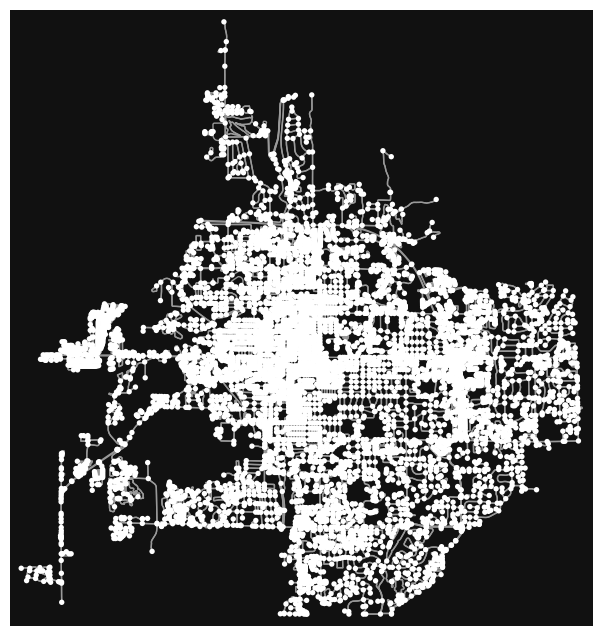

In [104]:
place_name = "Bloomington, Indiana"
# place_name = "Monroe County, Indiana"

G = ox.graph_from_place(place_name, network_type='bike')
fig, ax = ox.plot_graph(G)

In [105]:
amenity_dict = {'sustenance': ['bar', 'biergarten', 'cafe', 'fast_food', 
                               'food_court', 'ice_cream', 'pub', 'restaurant'],
                'education': ['college', 'driving_school', 'kindergarten', 
                              'language_school', 'library', 'toy_library',
                              'research_institute', 'training', 'music_school',
                              'school', 'traffic_park', 'university'],
                'financial': ['atm', 'bank', 'bureau_de_change'],
                'healthcare': ['baby_hatch', 'clinic', 'dentist', 'doctors',
                               'hospital', 'nursing_home', 'pharmacy',
                               'social_facility', 'veterinary'],
                'culture': ['arts_centre', 'brothel', 'casino', 'cinema',
                            'community_centre', 'conference_centre', 
                            'events_venue', 'exhibition_centre', 'fountain',
                            'gambling', 'love_hotel', 'music_venue', 
                            'nightclub', 'planetarium', 'public_bookcase',
                            'social_centre', 'stripclub', 'studio', 
                            'swingerclub', 'threatre'],
                'public': ['courthouse', 'fire_station', 'police', 
                           'post_box', 'post_depot', 'post_office',
                           'prison', 'ranger_station', 'townhall']}

sustenance = ox.features_from_place(place_name, tags={'amenity': amenity_dict['sustenance']})
education = ox.features_from_place(place_name, tags={'amenity': amenity_dict['education']})
financial = ox.features_from_place(place_name, tags={'amenity': amenity_dict['financial']})
healthcare = ox.features_from_place(place_name, tags={'amenity': amenity_dict['healthcare']})
culture = ox.features_from_place(place_name, tags={'amenity': amenity_dict['culture']})
public = ox.features_from_place(place_name, tags={'amenity': amenity_dict['public']})

sustenance = sustenance[['amenity', 'name', 'geometry']]
education = education[['amenity', 'name', 'geometry']]
financial = financial[['amenity', 'name', 'geometry']]
healthcare = healthcare[['amenity', 'name', 'geometry']]
culture = culture[['amenity', 'name', 'geometry']]
public = public[['amenity', 'name', 'geometry']]

/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.int

In [106]:
print(len(sustenance))
print(len(education))
print(len(financial))
print(len(healthcare))
print(len(culture))
print(len(public))

256
29
38
42
44
17


In [107]:
sustenance

amenity                      name   
element_type osmid                                              
node         471951774   restaurant          The Trojan Horse  \
             471951775         cafe               Uptown Cafe   
             668770696    fast_food                    Subway   
             668770697   restaurant        Buffalo Wild Wings   
             668770698   restaurant     Cloverleaf Restaurant   
...                             ...                       ...   
way          1044297849        cafe  Needmore Coffee Roasters   
             1131862666  restaurant              Malibu Grill   
             1131862671  restaurant            Social Cantina   
             1173197975  restaurant                 Che Bello   
relation     13964380    food_court                       NaN   

                                                                  geometry  
element_type osmid                                                          
node         471951774                          POINT (-86.53338 39.16645)  
             471951775                          POINT (-86.53328 39.16645)  
             668770696                          POINT (-86.55297 39.16065)  
             668770697                          POINT (-86.55273 39.16047)  
             668770698                          POINT (-86.58414 39.16416)  
...                                                                    ...  
way          1044297849  POLYGON ((-86.49457 39.16712, -86.49438 39.167...  
             1131862666  POLYGON ((-86.53345 39.16692, -86.53298 39.166...  
             1131862671  POLYGON ((-86.53549 39.16747, -86.53549 39.167...  
             1173197975  POLYGON ((-86.53382 39.16804, -86.53395 39.168...  
relation     13964380    POLYGON ((-86.49587 39.16210, -86.49582 39.162...  

[256 rows x 3 columns]

# CBG data

In [156]:
ymax = 39.220964
ymin = 39.119441
xmax = -86.472109
xmin = -86.591585

path = "../data/external/tl_rd22_18_bg"
gdf = gpd.read_file(path)
gdf = gdf.to_crs("EPSG:4326")
gdf = gdf.cx[xmin:xmax, ymin:ymax]
gdf = gdf.reset_index()

/Users/danielhankim/mambaforge/envs/data-visualization/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [157]:
gdf = gdf[['GEOID', 'TRACTCE', 'geometry']]
gdf

,GEOID,TRACTCE,geometry
0,181050005014,000501,"POLYGON ((-86.58634 39.14568, -86.58633 39.145..."
1,181050006013,000601,"POLYGON ((-86.56501 39.17101, -86.56500 39.171..."
2,181050008012,000801,"POLYGON ((-86.55510 39.18784, -86.55506 39.188..."
3,181050008021,000802,"POLYGON ((-86.51460 39.20067, -86.51452 39.200..."
4,181050009012,000901,"POLYGON ((-86.50945 39.16823, -86.50915 39.168..."
...,...,...,...
70,181050005023,000502,"POLYGON ((-86.60652 39.12788, -86.60530 39.128..."
71,181050016001,001600,"POLYGON ((-86.53471 39.17983, -86.53470 39.180..."
72,181050016002,001600,"POLYGON ((-86.53856 39.17361, -86.53855 39.173..."
73,181050016003,001600,"POLYGON ((-86.52836 39.17864, -86.52833 39.179..."


<Axes: >

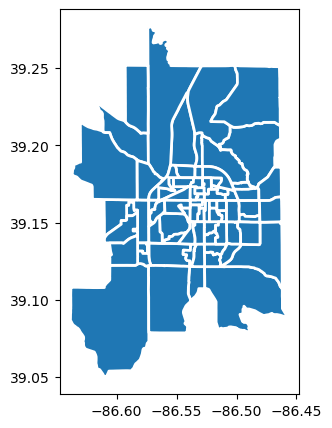

In [158]:
gdf.plot(figsize = (5, 5), lw = 2., ec = 'w')

# Calc average time

In [159]:
amenities = {'sustenance': sustenance,
             'education': education,
             'financial': financial,
             'healthcare': healthcare,
             'culture': culture,
             'public': public}

# Find the nearest node from the representative point of a CBG
gdf['rep_x'] = gdf['geometry'].representative_point().x
gdf['rep_y'] = gdf['geometry'].representative_point().y
gdf['node_id'] = ox.nearest_nodes(G, gdf['rep_x'], gdf['rep_y'])

for amenity_type, amenity_df in amenities.items():
    print(f'processing {amenity_type}')
    amenity_df['rep_x'] = amenity_df['geometry'].representative_point().x
    amenity_df['rep_y'] = amenity_df['geometry'].representative_point().y
    amenity_df['node_id'] = ox.nearest_nodes(G, amenity_df['rep_x'], amenity_df['rep_y'])

    distance_dict = {'node_id': [], f'{amenity_type}_distance': []}
    for cbg_node_id in tqdm(gdf['node_id']):
        distance = 0
        for amenity_node_id in amenity_df['node_id']:
            if cbg_node_id != amenity_node_id:
                route = ox.shortest_path(G, cbg_node_id, amenity_node_id, weight='length')
                distance += sum(ox.utils_graph.route_to_gdf(G, route, "length")["length"]) / len(amenity_df['node_id'])
        
        distance_dict['node_id'].append(cbg_node_id)
        distance_dict[f'{amenity_type}_distance'].append(distance)

    new_df = pd.DataFrame.from_dict(distance_dict)
    gdf = pd.merge(gdf, new_df, left_index=True, right_index=True)

    speed = 20 / 60 * 1000  # 20 km/h * 1h/60min * 1000m / 1km (source: https://bikecommuterhero.com/whats-the-average-cycling-speed-of-a-bike-commuter/?expand_article=1)
    gdf[f'{amenity_type}_time'] = gdf[f'{amenity_type}_distance'] / speed
    gdf.drop(columns=['node_id_y'], inplace=True)
    gdf.rename(columns={'node_id_x': 'node_id'}, inplace=True)
    
gdf

processing sustenance


100%|██████████| 75/75 [13:29<00:00, 10.79s/it]


processing education


100%|██████████| 75/75 [01:31<00:00,  1.22s/it]


processing financial


100%|██████████| 75/75 [01:59<00:00,  1.60s/it]


processing healthcare


100%|██████████| 75/75 [02:16<00:00,  1.82s/it]


processing culture


100%|██████████| 75/75 [02:21<00:00,  1.88s/it]


processing public


100%|██████████| 75/75 [00:53<00:00,  1.40it/s]


,GEOID,TRACTCE,geometry,rep_x,rep_y,node_id,sustenance_distance,sustenance_time,education_distance,education_time,financial_distance,financial_time,healthcare_distance,healthcare_time,culture_distance,culture_time,public_distance,public_time
0,181050005014,000501,"POLYGON ((-86.58634 39.14568, -86.58633 39.145...",-86.577947,39.150951,7555701751,7051.921848,21.155766,7628.912414,22.886737,7150.153079,21.450459,7264.239381,21.792718,7870.872682,23.612618,6859.463706,20.578391
1,181050006013,000601,"POLYGON ((-86.56501 39.17101, -86.56500 39.171...",-86.548252,39.171829,180585594,3275.553953,9.826662,3773.117586,11.319353,3707.368026,11.122104,4170.457762,12.511373,3898.244818,11.694734,2834.506294,8.503519
2,181050008012,000801,"POLYGON ((-86.55510 39.18784, -86.55506 39.188...",-86.544738,39.210217,7548213394,7042.669422,21.128008,7251.995966,21.755988,7460.417868,22.381254,7909.226119,23.727678,7562.312364,22.686937,6555.679647,19.667039
3,181050008021,000802,"POLYGON ((-86.51460 39.20067, -86.51452 39.200...",-86.484924,39.193585,2873940738,5720.451504,17.161355,5885.791862,17.657376,6127.701579,18.383105,6989.215786,20.967647,5553.457727,16.660373,5329.399588,15.988199
4,181050009012,000901,"POLYGON ((-86.50945 39.16823, -86.50915 39.168...",-86.504876,39.167928,180605646,3139.792711,9.419378,3490.833724,10.472501,3480.033711,10.440101,4438.861524,13.316585,2731.853795,8.195561,2775.143765,8.325431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,181050005023,000502,"POLYGON ((-86.60652 39.12788, -86.60530 39.128...",-86.593942,39.132421,180584797,9350.012379,28.050037,9924.605414,29.773816,9452.553895,28.357662,9559.932381,28.679797,10166.565682,30.499697,9155.156706,27.465470
71,181050016001,001600,"POLYGON ((-86.53471 39.17983, -86.53470 39.180...",-86.531491,39.182637,1743002581,3637.295473,10.911886,3989.585379,11.968756,4016.797079,12.050391,4830.523952,14.491572,4026.266295,12.078799,3037.740647,9.113222
72,181050016002,001600,"POLYGON ((-86.53856 39.17361, -86.53855 39.173...",-86.533021,39.175787,6594078975,2935.691195,8.807074,3458.563345,10.375690,3317.176868,9.951531,4093.541952,12.280626,3352.959818,10.058879,2309.149000,6.927447
73,181050016003,001600,"POLYGON ((-86.52836 39.17864, -86.52833 39.179...",-86.524657,39.173850,2860570800,2824.788289,8.474365,3254.667690,9.764003,3238.879500,9.716638,4174.199762,12.522599,2998.180795,8.994542,2196.228471,6.588685


In [1]:
gdf.to_csv('../data/processed/Bloomington_CBG_Amenity_15_Minute_Bike.csv', index=False)

NameError: name 'gdf' is not defined

<Axes: >

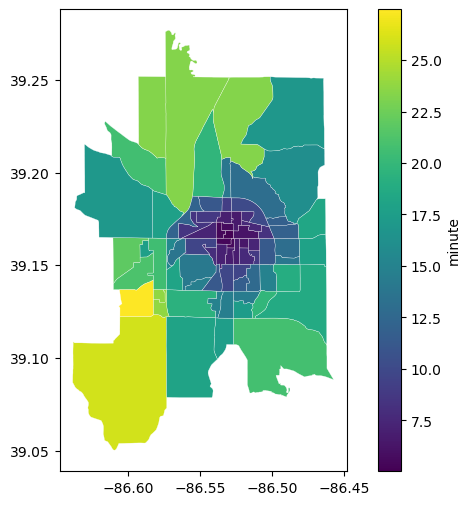

In [167]:
gdf.plot(figsize=(8, 6),
         column='public_time',
         legend=True, 
         ec='w',
         lw=0.2,
         legend_kwds={"label": "minute", "orientation": "vertical"})

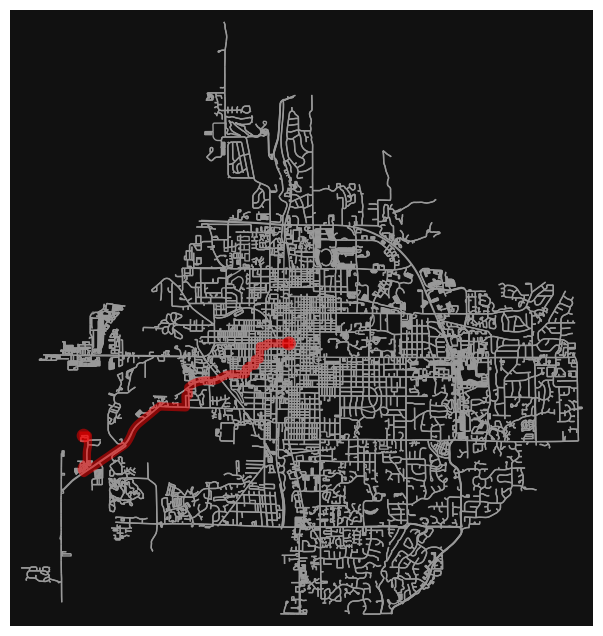

In [24]:
# plot the routes
fig, ax = ox.plot_graph_route(G, 
                              route=sp_routes[0], 
                              route_color="r", 
                              route_linewidth=6, 
                              node_size=0)

In [187]:
route_length = int(sum(ox.utils_graph.route_to_gdf(G, route[0], "length")["length"]))
route_time = int(sum(ox.utils_graph.route_to_gdf(G, route[0], "travel_time")["travel_time"]))
print("Route is", route_length, "meters and takes", route_time, "seconds.")

Route is 4524 meters and takes 727 seconds.


In [68]:
# Find the nearest node from the representative point of a CBG
gdf['rep_x'] = gdf['geometry'].representative_point().x
gdf['rep_y'] = gdf['geometry'].representative_point().y
gdf['node_id'] = ox.nearest_nodes(G, gdf['rep_x'], gdf['rep_y'])

# Find the nearest node from the representative point of an amenity
sustenance['rep_x'] = sustenance['geometry'].representative_point().x
sustenance['rep_y'] = sustenance['geometry'].representative_point().y
sustenance['node_id'] = ox.nearest_nodes(G, sustenance['rep_x'], sustenance['rep_y'])


distance_dict = {'node_id': [], 'sustenance_distance': []}
for cbg_node_id in tqdm(gdf['node_id']):
    distance = 0
    for amenity_node_id in sustenance['node_id']:
        if cbg_node_id != amenity_node_id:
            route = ox.shortest_path(G, cbg_node_id, amenity_node_id, weight='length')
            distance += sum(ox.utils_graph.route_to_gdf(G, route, "length")["length"]) / len(sustenance['node_id'])
    
    distance_dict['node_id'].append(cbg_node_id)
    distance_dict['sustenance_distance'].append(distance)

new_df = pd.DataFrame.from_dict(distance_dict)
gdf = pd.merge(gdf, new_df, on='node_id')


# Divide the path length with speed and the average travel time
speed = 20 / 60 * 1000  # 20 km/h * 1h/60min * 1000m / 1km (source: https://bikecommuterhero.com/whats-the-average-cycling-speed-of-a-bike-commuter/?expand_article=1)
gdf['sustenance_time'] = gdf['sustenance_distance'] / speed

gdf


100%|██████████| 75/75 [13:07<00:00, 10.50s/it]


,GEOID,TRACTCE,geometry,rep_x,rep_y,node_id,sustenance_distance,sustenance_time
0,181050005014,000501,"POLYGON ((-86.58634 39.14568, -86.58633 39.145...",-86.577947,39.150951,7555701751,7051.921848,21.155766
1,181050006013,000601,"POLYGON ((-86.56501 39.17101, -86.56500 39.171...",-86.548252,39.171829,180585594,3275.553953,9.826662
2,181050008012,000801,"POLYGON ((-86.55510 39.18784, -86.55506 39.188...",-86.544738,39.210217,7548213394,7042.669422,21.128008
3,181050008021,000802,"POLYGON ((-86.51460 39.20067, -86.51452 39.200...",-86.484924,39.193585,2873940738,5720.451504,17.161355
4,181050009012,000901,"POLYGON ((-86.50945 39.16823, -86.50915 39.168...",-86.504876,39.167928,180605646,3139.792711,9.419378
...,...,...,...,...,...,...,...,...
78,181050005023,000502,"POLYGON ((-86.60652 39.12788, -86.60530 39.128...",-86.593942,39.132421,180584797,9350.012379,28.050037
79,181050016001,001600,"POLYGON ((-86.53471 39.17983, -86.53470 39.180...",-86.531491,39.182637,1743002581,3637.295473,10.911886
80,181050016002,001600,"POLYGON ((-86.53856 39.17361, -86.53855 39.173...",-86.533021,39.175787,6594078975,2935.691195,8.807074
81,181050016003,001600,"POLYGON ((-86.52836 39.17864, -86.52833 39.179...",-86.524657,39.173850,2860570800,2824.788289,8.474365
